**Chapter 1 – The Machine Learning landscape**

_This is the code used to generate some of the figures in chapter 1._

# Code example 1-1

Although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead.

In [1]:
# Python ≥3.5 is required
import sys
import os
import numpy as np
import pandas as pd
assert sys.version_info >= (3, 5)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

This function just merges the OECD's life satisfaction data and the IMF's GDP per capita data. It's a bit too long and boring and it's not specific to Machine Learning, which is why I left it out of the book.

## Description CSDC

The following code fragment accepts the dataframes for the 'Better life index' and the GDP as input parameters, then merges the dataframes on the country.

The reason why he drop severals data sets is not quite clear, but we add Austria to the locations to be dropped from the frame to avoid biassing the training set. Furthermore we also return austria from the function for later comparison with our predictions.

In [3]:
def prepare_country_stats(oecd_bli, gdp_per_capita):

    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    austria_loc = full_country_stats.index.get_loc("Austria")
    austria = pd.DataFrame(full_country_stats.iloc[austria_loc])
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    remove_indices.append(austria_loc)
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices], austria

The code in the book expects the data files to be located in the current directory. I just tweaked it here to fetch the files in datasets/lifesat.

In [4]:
import os
datapath = os.path.join("datasets", "lifesat", "")

In [5]:
# To plot pretty figures directly within Jupyter
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
# Download the data
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

# Load all data

In [7]:
# Code example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats, austria = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]


## Linear Regression - Description CSDC

The previously defined method is called and a dataframe containing Country as index, GDP and life satisfaction is retrieved. The training set is then extracted from the dataframe, X being the training data and y the corresponding label.

The stats are then plotted as a scatter plot.

The model is then trained via `model.fit()` with X and y, furthermore a prediction is made for austria via `model.predict()`.

Furthermore we've predicted the y for all values that were previously already fed to the model. Since the model already knows these values, this only makes sense for graphical purposes. Ideally we would have a test set, on which we run the prediction on to see the performance of the model. 

Since the training set is already very small, we did not split it any further into training and test set, as in that case, we'd just give more way to overfitting, but we're very much aware that this would be required and optimally go even further by splitting it into training, test and validation set.

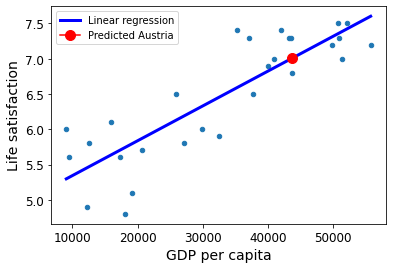

In [8]:
# Select a linear model
lin_model = sklearn.linear_model.LinearRegression()

# Train the model
lin_model.fit(X, y)
# Predict for all
overall_prediction_lin = lin_model.predict(X)

# Make a prediction for Austria
X_austria = [[43724.031]]  # Austria' GDP per capita
austria_prediction_lin = lin_model.predict(X_austria) # outputs [[7.00612271]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.plot(X, overall_prediction_lin, color='blue', linewidth=3, label='Linear regression')
plt.plot(X_austria, austria_prediction_lin, color='red', marker='o', markersize=10, label="Predicted Austria")
#plt.gca().set_ylim(bottom=0)
#plt.gca().set_ylim(top=10)
plt.legend()
plt.show()

## Polynomial Regression - Description CSDC

In summary polynomial regression functions similar to linear regression / regression with 1st degree polynomials only. Using polynomial regression allows the regression to make use of higher order polynomials (capped with a setting), as well as combinations of the features (1, a, b, a^2, ab, b^2, ...). 

Doing so allows the regression to better fit to the dataset, but allowing too high order polynomials also increases the risk of overfitting.

We define the 
* PolynomialFeatures, which cap the allowed polynomial degree
* StandardScaler, which helps to smooth out the curve by standardizing features removing the mean and scaling to unit variance
* LinearRegression, as used above
* Pipeline, which determines in which order the mentioned components are applied, the pipeline is then used to fit the model (via the final estimator), as well as predict the model.

Initially we would have chosen 4th degree polynomials, since it fit the data quite well, but we've seen that quadratic features were requsted. We've added both as a separate plot to display the difference.



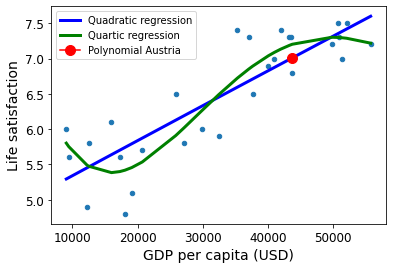

In [9]:
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model

# Set up components
poly_2 = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly_4 = preprocessing.PolynomialFeatures(degree=4, include_bias=False)
scaler_2 = preprocessing.StandardScaler()
scaler_4 = preprocessing.StandardScaler()
lin_reg_2 = linear_model.LinearRegression()
lin_reg_4 = linear_model.LinearRegression()

# Apply components
pipeline_reg_2 = pipeline.Pipeline([('poly', poly_2), ('scal', scaler_2), ('lin', lin_reg_2)])
pipeline_reg_4 = pipeline.Pipeline([('poly', poly_4), ('scal', scaler_4), ('lin', lin_reg_4)])

# Fit the model
pipeline_reg_2.fit(X, y)
pipeline_reg_4.fit(X, y)

# Make a prediction for Austria
austria_prediction_poly_2 = pipeline_reg_2.predict(X_austria) # outputs [[7.16886356]]
austria_prediction_poly_4 = pipeline_reg_4.predict(X_austria) # outputs [[7.16886356]]

# Predict for all
curve_2 = pipeline_reg_2.predict(X)
curve_4 = pipeline_reg_4.predict(X)

# Plot the results
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.plot(X, curve_2,color='blue', linewidth=3, label='Quadratic regression')
plt.plot(X, curve_4,color='green', linewidth=3, label='Quartic regression')
plt.plot(X_austria, austria_prediction_poly_2, color='red', marker='o', markersize=10, label="Polynomial Austria")
plt.xlabel("GDP per capita (USD)")
plt.legend()
plt.show()


## Ridge Regression and Bayesian Ridge - Description CSDC  

### Ridge Regression  

Small number of measurements in the training data lead to over fitting of the model and to high variance. To reduce the variance the main idea of ridge regression is to introduce some small amount of bias into the data to find a new line which does not fit the training data as well but reduces the variance. So by having a slightly worse fit data better long term predictions can be provided.  
So while the least squared error in linear regression minimises the sum of squared residuals, ridge regression minimises the sum of squared residuals **plus** the ridge regression penalty **lambda * theta^2**. This increases the variance in the training set but decreases it in the test set.  
If theta is for example the slope of a linear curve choosing lambda and with that increasing/decreasing the slope of the ridge regression line the sensitivity of the penalty can be adjusted. For example if the slope is very steep the y-axis respond very sensitively on changes of the x-axis and vice versa.  
To estimate the best value for lambda cross validation is used, cross validation means trying different values for lambda and choosing the lambda which brought the best results.  


### Bayesian Ridge Regression  

In Bayesian statistics the parameters we want to infer are random variables, meaning their distributions, expected values, variances, confidence, intervals and so on can be calculated. So to compute the probability distribution Bayes rule can be used: the distribution is proportional to the product of its prior distribution and the likelihood function related to that parameter. The Bayesian approach is then to estimate a parameter (the vector of betas) by maximizing its posterior probability, given the actual sample of data. If the random variables Y and Beta have independent normal distributions and set lambda to sigma^2/c the ridge regression is obtained.


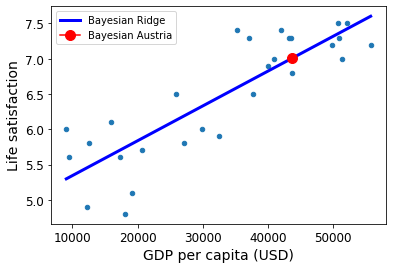

In [10]:
# Create the bayesian modle without defining any further hyperparameters
baye_reg = linear_model.BayesianRidge()
baye_model = baye_reg.fit(X, y.ravel())

# Make a prediction for Austria
X_austria = [[43724.031]]  # Austria' GDP per capita
austria_prediction_baye = baye_model.predict(X_austria) # outputs [[7.00611405]]

# Overall prediction
overall_prediction_baye = baye_model.predict(X)

# Plot the results
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.plot(X, overall_prediction_baye,color='blue', linewidth=3, label='Bayesian Ridge')
plt.plot(X_austria, austria_prediction_baye, color='red', marker='o', markersize=10, label="Bayesian Austria")
plt.xlabel("GDP per capita (USD)")
plt.legend()
plt.show()


# Plotting all results

In [11]:
def print_performance(**kwargs):
    offset_dict = dict()
    for key, value in kwargs.items():
        offset = float(austria.loc['Life satisfaction']) - value
        offset_dict[key] = abs(float(offset))
        print(f"{key}: {value}, Prediction offset: {offset}")
    print(f"{min(offset_dict, key=offset_dict.get)} has the minimal offset")
    

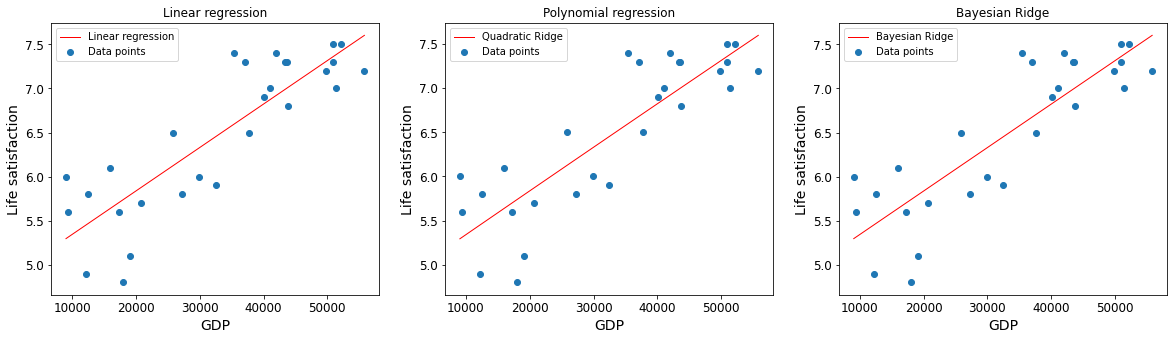

Performance Austria:
bayesian_ridge: [7.00611405], Prediction offset: [-0.10611405]
linear_regression: [[7.00612271]], Prediction offset: [[-0.10612271]]
polynomial_regression: [[7.00672418]], Prediction offset: [[-0.10672418]]
bayesian_ridge has the minimal offset


In [12]:
X = np.array(country_stats['GDP per capita']).reshape(len(country_stats['GDP per capita']), 1)
y = np.array(country_stats['Life satisfaction']).reshape(len(country_stats['GDP per capita']), 1)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Linear regression

ax[0].set_title("Linear regression")
ax[0].scatter(X, y, label="Data points")
ax[0].plot(X, overall_prediction_lin, color='red', linewidth=1, label='Linear regression')
ax[0].set_xlabel("GDP")
ax[0].set_ylabel("Life satisfaction")
ax[0].legend()

# Polynomial regression

ax[1].set_title("Polynomial regression")
ax[1].scatter(X, y, label="Data points")
ax[1].plot(X, curve_2,color='red', linewidth=1, label='Quadratic Ridge')
ax[1].set_xlabel("GDP")
ax[1].set_ylabel("Life satisfaction")
ax[1].legend()


# Bayesian Ridge

ax[2].set_title("Bayesian Ridge")
ax[2].scatter(X, y, label="Data points")
ax[2].plot(X, overall_prediction_baye,color='red', linewidth=1, label='Bayesian Ridge')
ax[2].set_xlabel("GDP")
ax[2].set_ylabel("Life satisfaction")
ax[2].legend()


plt.show()

print("Performance Austria:")
print_performance(bayesian_ridge=austria_prediction_baye, linear_regression=austria_prediction_lin,polynomial_regression=austria_prediction_poly_2)


## Just a math example to play with linear regression (thomas)
Generating a fictional relation between weights and heights here to apply linear regression to it.

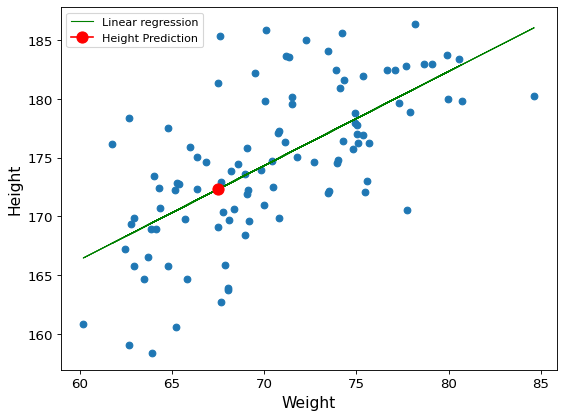

In [13]:
from numpy.random import default_rng
import seaborn as sns
rng = default_rng()
mean = [70, 175] 
cov = [[30, 20], [20,40]] # Connection of covariants unclear
size = (100,1)
multi = rng.multivariate_normal(mean , cov ,size)
weight = multi[:,0,0].reshape(100,1)
height = multi[:,0,1].reshape(100,1)


# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(weight, height)


# Make a prediction for a single weight
single_weight = [[67.5]]
heigth_prediction = model.predict(single_weight)

# Visualize the data

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.xlabel("Weight")
plt.ylabel("Height")
plt.scatter(weight, height)
predicted_values = model.predict(weight)
plt.plot(weight, predicted_values, color='green', linewidth=1, label='Linear regression')
plt.plot(single_weight, heigth_prediction, color='red', marker='o', markersize=10, label="Height Prediction")
plt.legend()
plt.savefig("weight-height.png")
plt.show()

